In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import inspect
import pandas as pd
import copy
import seaborn as sns
import networkx as nx
import random

import matplotlib
matplotlib.use('Agg')
from matplotlib import gridspec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.font_manager as font_manager
font_dirs = ['/mnt/e/Misc/Python_Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'tahoma'
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.stats import hypergeom
from matplotlib import gridspec

from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import make_lsq_spline
from scipy.interpolate import LSQUnivariateSpline
from scipy.stats.mstats import gmean

from mpl_toolkits.mplot3d import Axes3D
#%matplotlib notebook
%matplotlib inline
#%pylab

from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.patches as patches


In [2]:
org_sepcific = []
vrg_specific = []
rg_general = []
org_de = []
vrg_de = []
with open('/mnt/e/MPIMG/Elkabetz/scrna/public_data/data/pollen_2015/pca_analyses.tsv','r') as pca_fn:
    for i,row in enumerate(pca_fn):
        spl = row.strip("\n").split("\t")
        if spl[1] == 'ORG specificity': org_sepcific = spl[-1].strip(";").split(";")
        elif spl[1] == 'VRG specificity': vrg_specific = spl[-1].strip(";").split(";")
        elif spl[1] == 'General RG specificity': rg_general = spl[-1].strip(";").split(";")
        elif spl[1] == 'Up in ORG': org_de = spl[-1].strip(";").split(";")
        elif spl[1] == 'Up in VRG': vrg_de = spl[-1].strip(";").split(";")

In [3]:
org_markers = {}
vrg_markers = {}
with open('/mnt/e/MPIMG/Elkabetz/scrna/public_data/data/pollen_2015/pollen_org_vrg_comp.tsv','r') as deseq_fn:
    for i,row in enumerate(deseq_fn):
        spl = row.strip("\n").split("\t")
        if i == 0: continue
        try:
            if float(spl[-1]) < 0.1:
                if abs(float(spl[1])) > 1:
                    if float(spl[1]) > 0:
                        org_markers[spl[0]] = float(spl[1])
                    else:
                        vrg_markers[spl[0]] = float(spl[1])
        except:
            pass

In [4]:
c5_v_c12 = {}
with open('/mnt/e/MPIMG/Elkabetz/scrna/d50_organoids/c1andc2_v_c5.tsv','r') as rg_n_fn:
    for i,row in enumerate(rg_n_fn):
        spl = row.strip("\n").split("\t")
        if i == 0: continue
        gene,mean_expr,log_fc,type_,pval_adj,pct_1,pct_2 = spl[0],float(spl[3]),float(spl[4]),spl[1],float(spl[-1]),float(spl[5]),float(spl[6])
        if type_ == 'NSC': continue
        if gene not in c5_v_c12: c5_v_c12[gene] = {}
        c5_v_c12[gene] = {'log_fc':log_fc,'pval_adj':pval_adj,'pct.1':pct_1,'pct.2':pct_2,'mean_expr':mean_expr}

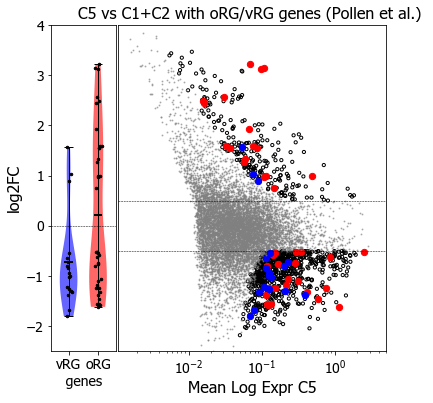

In [7]:
pct_cutoff = 0.02
colors = ['gray','red','blue']
xs = {'vrg':[],'org':[],'other':[]}
ys = {'vrg':[],'org':[],'other':[]}
zs = {'vrg':[],'org':[],'other':[]}
genes = {'vrg':[],'org':[],'other':[]}
sig_gene_set_up = set([])
sig_gene_set_down = set([])
all_genes_check = set([])
plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(1,20,wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[4:])
for gene in c5_v_c12.keys():
    all_genes_check.add(gene)
    if max(c5_v_c12[gene]['pct.1'],c5_v_c12[gene]['pct.2']) < pct_cutoff: continue
    log_fc,pval_adj,mean_expr = c5_v_c12[gene]['log_fc'],c5_v_c12[gene]['pval_adj'],c5_v_c12[gene]['mean_expr']
    if log_fc > 0.5 and 10**(-pval_adj) < 0.1:
        sig_gene_set_up.add(gene)
    elif log_fc < -0.5 and 10**(-pval_adj) < 0.1:
        sig_gene_set_down.add(gene)
    if gene in org_genes:
        xs['org'].append(mean_expr)
        ys['org'].append(log_fc)
        zs['org'].append(pval_adj)
        genes['org'].append(gene)
    elif gene in vrg_genes:
        xs['vrg'].append(mean_expr)
        ys['vrg'].append(log_fc)
        zs['vrg'].append(pval_adj)
        genes['vrg'].append(gene)
    else:
        xs['other'].append(mean_expr)
        ys['other'].append(log_fc)
        zs['other'].append(pval_adj)
        genes['other'].append(gene)
for g_set,color in zip(['other','org','vrg'],colors):
    if g_set == 'other':
        plt.scatter([xs[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] < 0.1 and abs(ys[g_set][i]) > 0.5],
                [ys[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] < 0.1 and abs(ys[g_set][i]) > 0.5],
                s=10,alpha=1,facecolors='none',edgecolors='black')
    else:
        plt.scatter([xs[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] < 0.1 and abs(ys[g_set][i]) > 0.5],
                [ys[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] < 0.1 and abs(ys[g_set][i]) > 0.5],
                c=color,s=40,alpha=1)
    if g_set == 'vrg':
        for i in range(len(ys[g_set])):
            if 10**(-ys[g_set][i]) < 0.1 and abs(xs[g_set][i]) > 0.5:
                print(genes[g_set][i],xs[g_set][i],10**(-ys[g_set][i]))
    plt.scatter([xs[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] >= 0.1 or abs(ys[g_set][i]) <= 0.5],
                [ys[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] >= 0.1 or abs(ys[g_set][i]) <= 0.5],
                c='gray',alpha=0.5,s=1)

#for gene in ['PALLD','DACH1','SALL1','HOPX','RTN1','LIFR']:
#    print(gene,c5_v_c12[gene]['mean_expr'],c5_v_c12[gene]['log_fc'],c5_v_c12[gene]['pval_adj'])
#    plt.annotate(gene,xy=(c5_v_c12[gene]['mean_expr'],c5_v_c12[gene]['log_fc']))
    
plt.title('C5 vs C1+C2 with oRG/vRG genes (Pollen et al.) ',fontsize=16)
plt.ylim(-2.5,4)
plt.yticks([])
plt.axhline(0.5,linestyle='--',color='black',linewidth=0.5)
plt.axhline(-0.5,linestyle='--',color='black',linewidth=0.5)
plt.xlabel('Mean Log Expr C5',fontsize=16)
plt.xticks([0,0.5,1,1.5,2,2.5],[0,0.5,1,1.5,2,2.5],fontsize=14)
plt.xscale('log')
plt.xlim(0.0011,5)

ax = plt.subplot(gs[:4])
cell_types = ['vrg','org']
positions = []
vals = []
colors_ = []
for j,cell_type in enumerate(cell_types):
    colors_.append(color_dict[cell_type])
    vals.append([ys[cell_type][j] for j,gene in enumerate(genes[cell_type]) if 
                 zs[cell_type][j] < 0.1 and abs(ys[cell_type][j]) > 0.5])
    positions.append(j)

vp = ax.violinplot(vals, positions, points=40, widths=0.6,
                  showmeans=True, showextrema=True, vert=True)

for j,patch in enumerate(vp['bodies']):
    patch.set_facecolor(colors_[j])
    patch.set_alpha(0.6)
for feature in ['cbars','cmins','cmaxes','cmeans']:
    vp[feature].set_color('black')
    if feature == 'cmeans':
        vp[feature].set_linewidth(2)
    else:
        vp[feature].set_linewidth(1)

## make point plots
for val,pos,col in zip(vals,positions,colors):
    plt.plot([pos]*len(val)+np.random.randn(len(val))*0.05,val,'.',markersize=5,color='black',zorder=2)

plt.axhline(0,linestyle='--',color='black',linewidth=0.5)
plt.ylim(-2.5,4)
plt.xlim(-0.6,1.6)
plt.ylabel('log2FC',fontsize=16)
plt.yticks(fontsize=14)
plt.xticks([0,1],['vRG\n       genes','oRG'],fontsize=14)
plt.show()

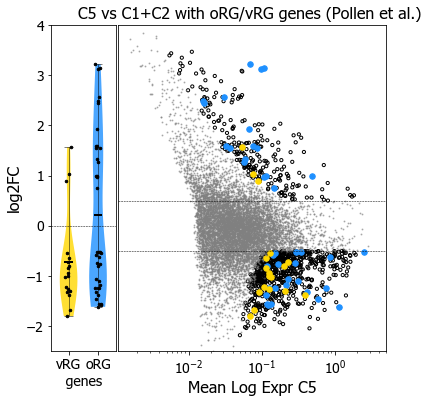

In [9]:
pct_cutoff = 0.02
colors = ['gray','dodgerblue','gold']
color_dict = {'vrg':'gold','org':'dodgerblue'}
xs = {'vrg':[],'org':[],'other':[]}
ys = {'vrg':[],'org':[],'other':[]}
zs = {'vrg':[],'org':[],'other':[]}
genes = {'vrg':[],'org':[],'other':[]}
sig_gene_set_up = set([])
sig_gene_set_down = set([])
all_genes_check = set([])
plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(1,20,wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[4:])
for gene in c5_v_c12.keys():
    all_genes_check.add(gene)
    if max(c5_v_c12[gene]['pct.1'],c5_v_c12[gene]['pct.2']) < pct_cutoff: continue
    log_fc,pval_adj,mean_expr = c5_v_c12[gene]['log_fc'],c5_v_c12[gene]['pval_adj'],c5_v_c12[gene]['mean_expr']
    if log_fc > 0.5 and 10**(-pval_adj) < 0.1:
        sig_gene_set_up.add(gene)
    elif log_fc < -0.5 and 10**(-pval_adj) < 0.1:
        sig_gene_set_down.add(gene)
    if gene in org_genes:
        xs['org'].append(mean_expr)
        ys['org'].append(log_fc)
        zs['org'].append(pval_adj)
        genes['org'].append(gene)
    elif gene in vrg_genes:
        xs['vrg'].append(mean_expr)
        ys['vrg'].append(log_fc)
        zs['vrg'].append(pval_adj)
        genes['vrg'].append(gene)
    else:
        xs['other'].append(mean_expr)
        ys['other'].append(log_fc)
        zs['other'].append(pval_adj)
        genes['other'].append(gene)
for g_set,color in zip(['other','org','vrg'],colors):
    if g_set == 'other':
        plt.scatter([xs[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] < 0.1 and abs(ys[g_set][i]) > 0.5],
                [ys[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] < 0.1 and abs(ys[g_set][i]) > 0.5],
                s=10,alpha=1,facecolors='none',edgecolors='black')
    else:
        plt.scatter([xs[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] < 0.1 and abs(ys[g_set][i]) > 0.5],
                [ys[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] < 0.1 and abs(ys[g_set][i]) > 0.5],
                c=color,s=30,alpha=1)
    if g_set == 'vrg':
        for i in range(len(ys[g_set])):
            if 10**(-ys[g_set][i]) < 0.1 and abs(xs[g_set][i]) > 0.5:
                print(genes[g_set][i],xs[g_set][i],10**(-ys[g_set][i]))
    plt.scatter([xs[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] >= 0.1 or abs(ys[g_set][i]) <= 0.5],
                [ys[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] >= 0.1 or abs(ys[g_set][i]) <= 0.5],
                c='gray',alpha=0.5,s=1)

#for gene in ['PALLD','DACH1','SALL1','HOPX','RTN1','LIFR']:
#    print(gene,c5_v_c12[gene]['mean_expr'],c5_v_c12[gene]['log_fc'],c5_v_c12[gene]['pval_adj'])
#    plt.annotate(gene,xy=(c5_v_c12[gene]['mean_expr'],c5_v_c12[gene]['log_fc']))
    
plt.title('C5 vs C1+C2 with oRG/vRG genes (Pollen et al.) ',fontsize=16)
plt.ylim(-2.5,4)
plt.yticks([])
plt.axhline(0.5,linestyle='--',color='black',linewidth=0.5)
plt.axhline(-0.5,linestyle='--',color='black',linewidth=0.5)
plt.xlabel('Mean Log Expr C5',fontsize=16)
plt.xticks([0,0.5,1,1.5,2,2.5],[0,0.5,1,1.5,2,2.5],fontsize=14)
plt.xscale('log')
plt.xlim(0.0011,5)

ax = plt.subplot(gs[:4])
cell_types = ['vrg','org']
positions = []
vals = []
colors_ = []
for j,cell_type in enumerate(cell_types):
    colors_.append(color_dict[cell_type])
    vals.append([ys[cell_type][j] for j,gene in enumerate(genes[cell_type]) if 
                 zs[cell_type][j] < 0.1 and abs(ys[cell_type][j]) > 0.5])
    positions.append(j)

vp = ax.violinplot(vals, positions, points=40, widths=0.6,
                  showmeans=True, showextrema=True, vert=True)

for j,patch in enumerate(vp['bodies']):
    patch.set_facecolor(colors_[j])
    patch.set_alpha(0.8)
for feature in ['cbars','cmins','cmaxes','cmeans']:
    vp[feature].set_color('black')
    if feature == 'cmeans':
        vp[feature].set_linewidth(2)
    else:
        vp[feature].set_linewidth(0.5)

## make point plots
for val,pos,col in zip(vals,positions,colors):
    plt.plot([pos]*len(val)+np.random.randn(len(val))*0.05,val,'.',markersize=5,color='black',zorder=2)

plt.axhline(0,linestyle='--',color='black',linewidth=0.5)
plt.ylim(-2.5,4)
plt.xlim(-0.6,1.6)
plt.ylabel('log2FC',fontsize=16)
plt.yticks(fontsize=14)
plt.xticks([0,1],['vRG\n       genes','oRG'],fontsize=14)
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/OSVZ_figure/v2/c12_v_c5.log_x.pdf')
plt.show()

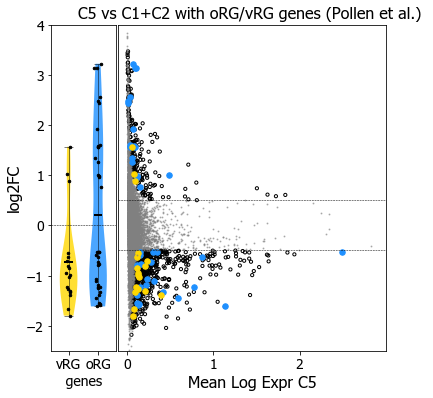

In [188]:
pct_cutoff = 0.02
colors = ['gray','dodgerblue','gold']
color_dict = {'vrg':'gold','org':'dodgerblue'}
xs = {'vrg':[],'org':[],'other':[]}
ys = {'vrg':[],'org':[],'other':[]}
zs = {'vrg':[],'org':[],'other':[]}
genes = {'vrg':[],'org':[],'other':[]}
sig_gene_set_up = set([])
sig_gene_set_down = set([])
all_genes_check = set([])
plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(1,20,wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[4:])
for gene in c5_v_c12.keys():
    all_genes_check.add(gene)
    if max(c5_v_c12[gene]['pct.1'],c5_v_c12[gene]['pct.2']) < pct_cutoff: continue
    log_fc,pval_adj,mean_expr = c5_v_c12[gene]['log_fc'],c5_v_c12[gene]['pval_adj'],c5_v_c12[gene]['mean_expr']
    if log_fc > 0.5 and 10**(-pval_adj) < 0.1:
        sig_gene_set_up.add(gene)
    elif log_fc < -0.5 and 10**(-pval_adj) < 0.1:
        sig_gene_set_down.add(gene)
    if gene in org_genes:
        xs['org'].append(mean_expr)
        ys['org'].append(log_fc)
        zs['org'].append(pval_adj)
        genes['org'].append(gene)
    elif gene in vrg_genes:
        xs['vrg'].append(mean_expr)
        ys['vrg'].append(log_fc)
        zs['vrg'].append(pval_adj)
        genes['vrg'].append(gene)
    else:
        xs['other'].append(mean_expr)
        ys['other'].append(log_fc)
        zs['other'].append(pval_adj)
        genes['other'].append(gene)
for g_set,color in zip(['other','org','vrg'],colors):
    if g_set == 'other':
        plt.scatter([xs[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] < 0.1 and abs(ys[g_set][i]) > 0.5],
                [ys[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] < 0.1 and abs(ys[g_set][i]) > 0.5],
                s=10,alpha=1,facecolors='none',edgecolors='black')
    else:
        plt.scatter([xs[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] < 0.1 and abs(ys[g_set][i]) > 0.5],
                [ys[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] < 0.1 and abs(ys[g_set][i]) > 0.5],
                c=color,s=30,alpha=1)
    if g_set == 'vrg':
        for i in range(len(ys[g_set])):
            if 10**(-ys[g_set][i]) < 0.1 and abs(xs[g_set][i]) > 0.5:
                print(genes[g_set][i],xs[g_set][i],10**(-ys[g_set][i]))
    plt.scatter([xs[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] >= 0.1 or abs(ys[g_set][i]) <= 0.5],
                [ys[g_set][i] for i in range(len(ys[g_set])) if zs[g_set][i] >= 0.1 or abs(ys[g_set][i]) <= 0.5],
                c='gray',alpha=0.5,s=1)

#for gene in ['PALLD','DACH1','SALL1','HOPX','RTN1','LIFR']:
#    print(gene,c5_v_c12[gene]['mean_expr'],c5_v_c12[gene]['log_fc'],c5_v_c12[gene]['pval_adj'])
#    plt.annotate(gene,xy=(c5_v_c12[gene]['mean_expr'],c5_v_c12[gene]['log_fc']))
    
plt.title('C5 vs C1+C2 with oRG/vRG genes (Pollen et al.) ',fontsize=16)
plt.ylim(-2.5,4)
plt.yticks([])
plt.axhline(0.5,linestyle='--',color='black',linewidth=0.5)
plt.axhline(-0.5,linestyle='--',color='black',linewidth=0.5)
plt.xlabel('Mean Log Expr C5',fontsize=16)
plt.xticks([0,1,2],[0,1,2,],fontsize=14)
#plt.xscale('log')
plt.xlim(-0.1,3)

ax = plt.subplot(gs[:4])
cell_types = ['vrg','org']
positions = []
vals = []
colors_ = []
for j,cell_type in enumerate(cell_types):
    colors_.append(color_dict[cell_type])
    vals.append([ys[cell_type][j] for j,gene in enumerate(genes[cell_type]) if 
                 zs[cell_type][j] < 0.1 and abs(ys[cell_type][j]) > 0.5])
    positions.append(j)

vp = ax.violinplot(vals, positions, points=40, widths=0.6,
                  showmeans=True, showextrema=True, vert=True)

for j,patch in enumerate(vp['bodies']):
    patch.set_facecolor(colors_[j])
    patch.set_alpha(0.8)
for feature in ['cbars','cmins','cmaxes','cmeans']:
    vp[feature].set_color('black')
    if feature == 'cmeans':
        vp[feature].set_linewidth(2)
    else:
        vp[feature].set_linewidth(0.5)

## make point plots
for val,pos,col in zip(vals,positions,colors):
    plt.plot([pos]*len(val)+np.random.randn(len(val))*0.05,val,'.',markersize=5,color='black',zorder=2)

plt.axhline(0,linestyle='--',color='black',linewidth=0.5)
plt.ylim(-2.5,4)
plt.xlim(-0.6,1.6)
plt.ylabel('log2FC',fontsize=16)
plt.yticks(fontsize=14)
plt.xticks([0,1],['vRG\n       genes','oRG'],fontsize=14)
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/OSVZ_figure/v2/c12_v_c5.pdf')
plt.show()

In [112]:
def calculate_es_score(ordered_gene_list,gene_set,q=1):
    n_h = len(set(gene_set).intersection(set([x[0] for x in ordered_gene_list])))
    n = len(ordered_gene_list)
    p_hit = 0
    p_miss = 0
    es_scores = []
    n_r = float(sum([abs(gene_score[1])**q for gene_score in ordered_gene_list if gene_score[0] in gene_set]))
    for i,(gene,score) in enumerate(ordered_gene_list):
        if gene in gene_set:
            p_hit += abs(score)**q/n_r
        else:
            p_miss += 1./(n-n_h)
        es_scores.append(p_hit-p_miss)
    return es_scores

def run_permutation(ordered_gene_list,gene_set,q=1):
    random_gene_subset = [g[0] for g in random.sample(ordered_gene_list,len(gene_set))]
    es_s = calculate_es_score(ordered_gene_list,random_gene_subset,q)
    return es_s

def permute(ordered_gene_list,gene_set,n_permute,q=1):
    gene_set_sub = list(set(gene_set).intersection(set([x[0] for x in ordered_gene_list])))
    permuted_max_es_scores = []
    permuted_min_es_scores = []
    for i in range(n_permute):
        if i%1000==0: print(i)
        es_scores = run_permutation(ordered_gene_list,gene_set_sub,q)
        permuted_max_es_scores.append(max(es_scores))
        permuted_min_es_scores.append(min(es_scores))
    return permuted_max_es_scores,permuted_min_es_scores

def make_enrichment_score_plot(fig,scores,ordered_gene_list,gene_set,gene_set_name='NA',color='black',reg_iter=0):
    plt.plot([0,len(ordered_gene_list)],[0,0],'--',color=color)
    scores.insert(0,0)
    plt.plot(scores,color=color)
    min_score = min(scores)
    max_score = max(scores)
    if abs(max_score) > abs(min_score):
        plt.plot([scores.index(max_score),scores.index(max_score)],[0,max_score],'--',color=color)
    else:
        plt.plot([scores.index(min_score),scores.index(min_score)],[0,min_score],'--',color=color)
    plt.plot([0,len(ordered_gene_list)],[-1-0.2*reg_iter,-1-0.2*reg_iter],'-',color='black')
    for i,gene in enumerate(ordered_gene_list):
        if gene[0] in gene_set:
            plt.plot([i+1,i+1],[-1-reg_iter*0.2-0.05,-1-reg_iter*0.2+0.05],'-',color=color)
    plt.ylim(-1 - reg_iter*0.2-0.1,1.1)
    plt.plot([0,0],[-2,-2],'-',color=color,label=gene_set_name)
    plt.ylabel('Enrichment Score',fontsize=14)
    plt.xlabel('Gene Rank',fontsize=14)
    #plt.title(gene_set_name,fontsize=18)
    plt.yticks([-1,-0.5,0,0.5,1],[-1,-0.5,0,0.5,1])
    return fig

#def add_logFC_hist(fig,gene_list,reg_iter=0):
#    for j,gene_iter in enumerate(gene_list):
#        plt.bar(j,gene_iter[0])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
org 0.6247 0.0057
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
vrg 0.0249 0.9682


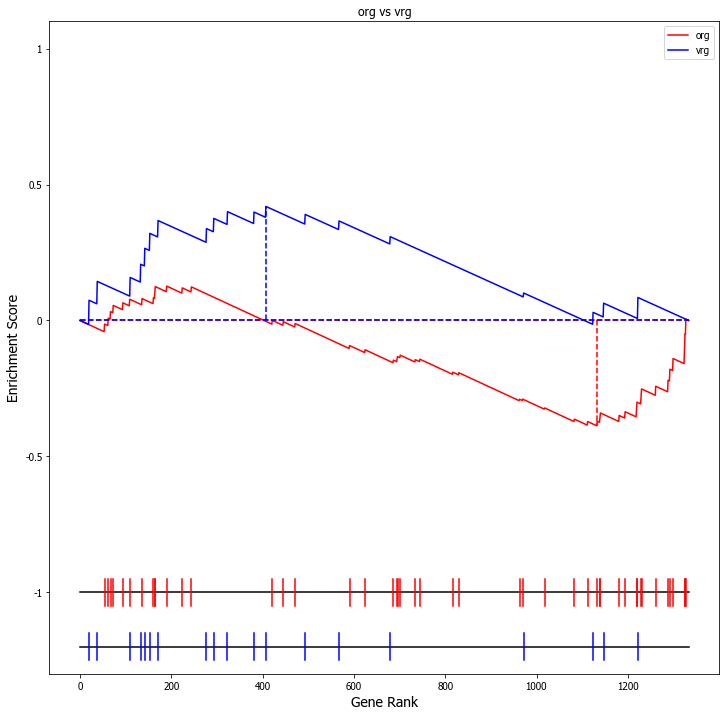

In [113]:
comp = 'org vs vrg'
gene_sets = {'org':org_genes,'vrg':vrg_genes}
n_permute = 10000

gene_list = []
for gene in c5_v_c12.keys():
    if max(c5_v_c12[gene]['pct.1'],c5_v_c12[gene]['pct.2']) < pct_cutoff: continue
    log_fc,pval_adj = c5_v_c12[gene]['log_fc'],c5_v_c12[gene]['pval_adj']
    if pval_adj < 0.1:
        gene_list.append((gene,log_fc))
gene_list = sorted(gene_list,key = lambda x:x[1])

fig = plt.figure(figsize=(12,12))

for j,reg in enumerate(gene_sets.keys()):
    gene_set = gene_sets[reg]
    scores = calculate_es_score(gene_list,gene_set)
    fig = make_enrichment_score_plot(fig,scores,gene_list,gene_set,gene_set_name=reg,color=color_dict[reg],reg_iter=j)
    if abs(max(scores)) > abs(min(scores)):
        direction = 'up'
    else:
        direction = 'down'
    if len(set(gene_set).intersection(set([x[0] for x in gene_list]))) >= 3:
        permuted_max_es_scores,permuted_min_es_scores = permute(gene_list,gene_set,n_permute)
        p_val_down = max(1./n_permute,len([x for x in permuted_min_es_scores if x < min(scores)])/float(n_permute))
        p_val_up = max(1./n_permute,len([x for x in permuted_max_es_scores if x > max(scores)])/float(n_permute))
    else:
        p_val_down = 1.
        p_val_up = 1.
    print(reg,p_val_up,p_val_down)
plt.legend()
plt.title(comp)
plt.show()

In [189]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
stats = importr('stats')

p_adjust = list(stats.p_adjust(FloatVector([0.0057,0.0249]), method = 'BH'))
print(p_adjust)

[0.0114, 0.0249]
